<center>  <h1> Lecture 4: Autoencoders </h1> </center> 
<center> Krishna Pillutla, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>


# Review: PCA
We start by recalling principal component analysis (PCA), a method you of dimensionality reduction. 

We can use an orthogonal projection matrix $W \in \mathbb{R}^{d \times k}$ ($k < d$) 
to project data $x_1, \cdots, x_n \in \mathbb{R}^d$ on a lower dimension $\mathbb{R}^k$ as 
$$
z_i = W^\top x_i .
$$
Since $W$ is an orthogonal (i.e., $W^\top W = I$), one can reconstruct $z \in \mathbb{R}^k$ as $\hat x = W z$, 
so that its projection is $W^\top \hat x = W^\top W z = z$.

PCA aims to find such a $W$ by minimizing the error of reconstruction: 
$$
    \min_W \frac{1}{n}\sum_{i=1}^n \| x_i - W W^\top x_i \|_2^2 \,.
$$

### Encoder-Decoder framework
The linear function $h(x) = W^\top x$ is an **encoder** -- it takes $x$ and returns its lower dimensional projection $W^\top x$. Similarly, the function $g(z) = Wz$ is a **decoder** -- it takes in a lower dimensional representation $z$ and returns a reconstruction $Wz$. Put together, PCA can be thought of as 
minimizing the reconstruction error $\|x - g(h(x))\|_2^2$ for the linear functions $g$ and $h$ we have just defined. 

<div>
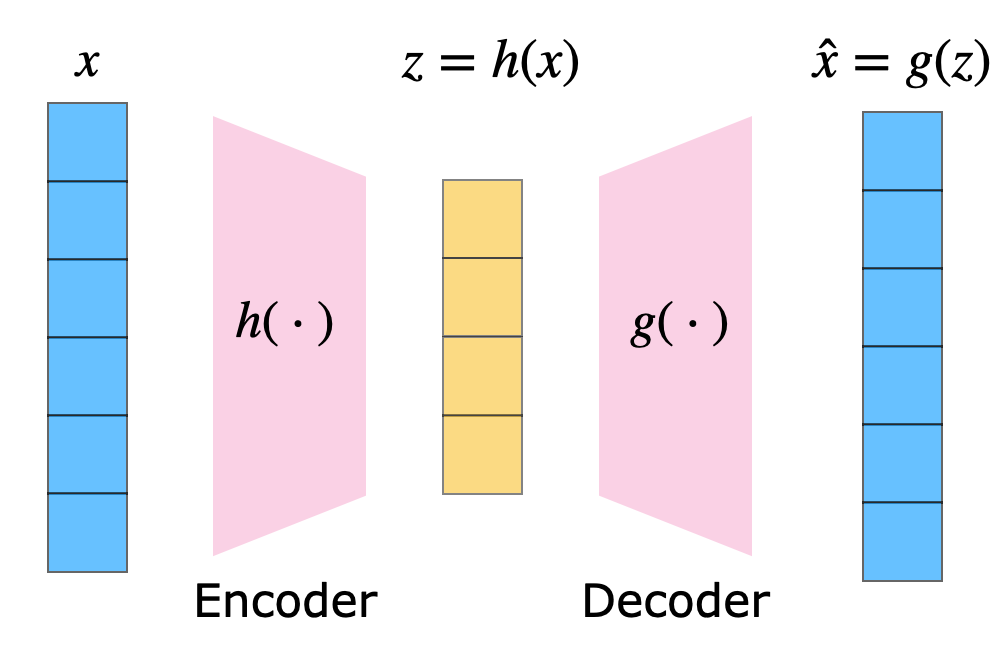
</div>


# Autoencoders 
Autoencoders take this idea further to general non-linear encoders and decoders. In this class, we will consider encoders and decoders parameterized by deep nets such as multilayer perceptrons or convolutional neural networks. 

<div>
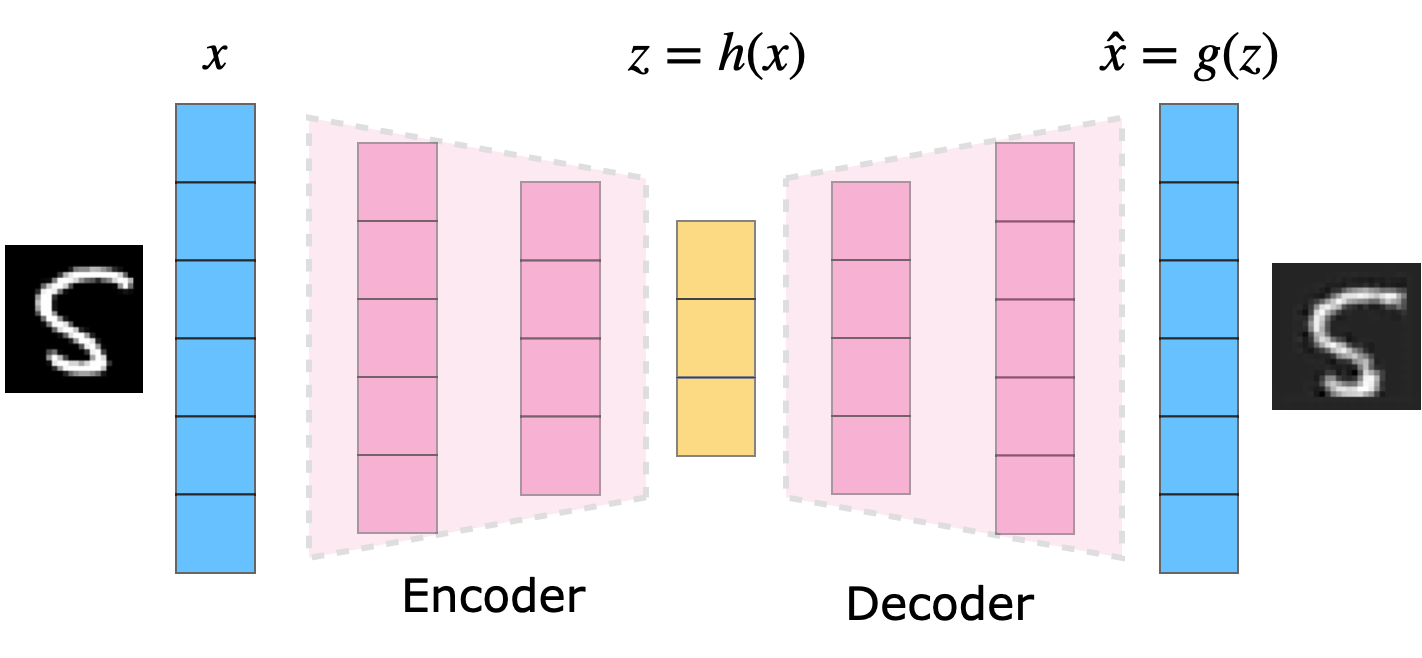
</div>


**Mathematical description**: Consider an encoder $h(\cdot; w): \mathbb{R}^d \to \mathbb{R}^{k}$ and a decoder $g(\cdot; v): \mathbb{R}^k \to \mathbb{R}^d$, both of which are neural networks with respective parameters denoted by $w$ and $v$. 
Our autoencoder aims to minimize the objective 
$$
    \min_{w, v} \frac{1}{n} \sum_{i=1}^n \|x_i - g(h(x_i; w) ; v)\|_2^2 .
$$



## Coding up the Model: Encoder

We will use a convolutional encoder, similar in spirit to the ConvNet we used for classification. The only difference is that it produces an output vector of a dimension of our choosing, rather than 10 corresponding to the output classes. 

As we discussed in class, we will use a strided convolution as an alternative to spatial pooling. **Exercise**: Figure out the right stride to get the desired output shape. 

In [1]:
import torch
from torch.nn.functional import relu

class EncoderModule(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        # Exercise: figure out the right stride in the "???" below to get the desired output shape
        # (B, 1, 28, 28) -> (B, 4, 12, 12)
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=5, stride=2, padding=0) 
        # Exercise: figure out the right stride in the "???" below to get the desired output shape
        # (B, 4, 12, 12) -> (B, 8, 5, 5)
        self.conv2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=0)
        # Flatten (B, 8, 5, 5) -> (B, 8*5*5): do this in `forward()`
        # (B, 8*5*5) -> (B, lower_dimension); 8*5*5 = 200
        self.linear = torch.nn.Linear(200, lower_dimension)
    
    def forward(self, images):
        out = relu(self.conv1(images))  # conv1 + relu
        #print(f'Layer 1 Shape: {out.shape}')
        out = relu(self.conv2(out))  # conv2 + relu
        #print(f'Layer 2 Shape: {out.shape}')
        out = out.view(out.shape[0], -1)  # flatten
        out = self.linear(out)  # Linear
        return out

In [2]:
input_size = 28
random_data = torch.randn(1, 1, input_size, input_size)

In [3]:
obj = EncoderModule(10)
obj(random_data)

tensor([[ 0.0991,  0.0120, -0.1222, -0.0580, -0.0613, -0.1459, -0.0051,  0.0262,
          0.0917, -0.0083]], grad_fn=<AddmmBackward0>)

## Decoder

The decoder architecture is designed to be able to approximately invert the operations performed by the encoder. In other words, the hidden shapes of the decoder will be the same as the encoder, but in reverse order. 

A linear layer is simply a matrix multiplication: it projects a vector $v \in \mathbb{R}^{d_1}$ to $v' \in \mathbb{R}^{d_2}$. Therefore, the decoder will aim to undo its work by using a linear map from $\mathbb{R}^{d_2}$ to $\mathbb{R}^{d_1}$, i.e., by inverting the input and output dimensions. 

In math, if the first operation is denoted by matrix $A$ and the second by $B$, then the shapes of $A$ and $B^\top$ are the same. In fact, this viewpoint is used to [define the transpose (a.k.a. adjoint)](https://en.wikipedia.org/wiki/Transpose_of_a_linear_map) more generally. 

In [4]:
# R^100 -> R^10 projection
down_project = torch.nn.Linear(100, 10)

# R^10 -> R^100 projection
up_project = torch.nn.Linear(10, 100)

x = torch.rand(1, 100)  # input is 100 dimensional (batch size = 1)
print(f"Input dimension = {x.shape}\n")

y = down_project(x)
print(f"Intermediate dimension = {y.shape}\n")

out = up_project(y) # Reconstruct
print(f"Output dimension = {out.shape}")

Input dimension = torch.Size([1, 100])

Intermediate dimension = torch.Size([1, 10])

Output dimension = torch.Size([1, 100])


**Transposing a convolution**:
A convolution is also a linear map, and therefore can be thought of an abstract matrix acting on the vectorized input. To build a corresponding layer in the decoder we need to specify the "transpose" of this abstract convolution matrix. 

Fortunately for us, PyTorch implements this operation, and it is called `ConvTranspose2D`. Here is an example. 

In [5]:
x = torch.rand(16, 1, 28, 28)  # batch size = 16, channels = 1, image shape = 28x28
print(f"Input shape = {x.shape}\n")

conv_layer = torch.nn.Conv2d(1, 4, kernel_size=5, stride=2, padding=0)

y = conv_layer(x)
print(f"Intermediate shape = {y.shape}\n")

# Transpose this operation. Note that input and output channels are interchanged
conv_transpose_layer = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0)
out = conv_transpose_layer(y)
print(f"Output shape = {out.shape}")

Input shape = torch.Size([16, 1, 28, 28])

Intermediate shape = torch.Size([16, 4, 12, 12])

Output shape = torch.Size([16, 1, 27, 27])


We do not recover our $28\times 28$ image size. Why is that? 

**Ans**: This is because the output is 27x27

We can make up the extra pixel by padding the output, as below. 

In [6]:
conv_transpose_layer_2 = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0, output_padding=1)
out = conv_transpose_layer_2(y)
print(f"Output shape = {out.shape}")

Output shape = torch.Size([16, 1, 28, 28])


Much better. This gives us the transpose of the first convolution.
 
Similarly, your exercise is to figure out the correct padding for the second convolution. 

In [7]:
x = torch.rand(1, 8, 5, 5)

# Exercise: What should the output_padding be so that the output shape is (1, 4, 12, 12)?
conv_transpose_layer = torch.nn.ConvTranspose2d(
    8, 4, kernel_size=3, stride=2, padding=0, output_padding=1
)

# We want the output to have shape (1, 4, 12, 12)
out = conv_transpose_layer(x)
print(f"Output shape = {out.shape}")

Output shape = torch.Size([1, 4, 12, 12])


In [8]:
class DecoderModule(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, lower_dimension) -> (B, linear)
        self.linear_t = torch.nn.Linear(lower_dimension, 200)
        # Unflatten (B, 8*5*5) -> (B, 8, 5, 5); do this in `forward()`
        # Exercise: plug in the output_padding values you determined above
        # (B, 8, 5, 5) -> (B, 4, 12, 12)
        self.conv2_t = torch.nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=0, output_padding=1)
        # (B, 4, 12, 12) -> (B, 1, 28, 28)
        self.conv1_t = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        # Apply in reverse order
        out = relu(self.linear_t(x))  # linear_t + relu
        #print(f'Layer 1 Shape: {out.shape}')
        out = out.view(out.shape[0], 8, 5, 5)  # Unflatten
        out = relu(self.conv2_t(out))  # conv2_t + relu
        #print(f'Layer 2 Shape: {out.shape}')
        out = self.conv1_t(out)  # conv1_t (note: no relu at the end)
        return out

In [9]:
input_size = 5
# random_data = torch.randn(1, 8, input_size, input_size)
random_data = torch.randn(1, 10)

In [10]:
dec_obj = DecoderModule(10)
dec_obj(random_data)

tensor([[[[-1.6333e-03,  3.7296e-03,  7.7592e-03,  1.3457e-02, -6.3155e-04,
            1.8601e-02, -9.3963e-03,  7.3025e-03, -1.4562e-03,  2.6962e-02,
           -1.2174e-02,  1.2412e-02, -1.6778e-02,  1.2906e-02, -2.3012e-02,
            1.1579e-02, -1.5815e-02,  2.0814e-02, -7.7871e-03,  1.4415e-02,
           -1.7013e-02,  2.4054e-02, -1.1781e-02,  1.0424e-02, -1.4457e-03,
            1.7725e-02, -4.0163e-03,  7.9973e-03],
          [ 2.4770e-02, -6.6127e-03,  2.9296e-02, -2.1913e-02,  1.9594e-02,
           -1.1462e-02,  2.0187e-02, -2.2539e-02,  3.0114e-02, -6.4932e-03,
            2.0573e-02, -2.8006e-02,  1.4005e-02, -4.0229e-02,  1.9044e-02,
           -3.7208e-02,  4.0151e-02, -3.0629e-02,  2.6656e-02, -5.2170e-02,
            2.1570e-02, -2.5261e-02,  1.3401e-02, -2.9653e-02,  3.4516e-03,
           -7.3034e-03,  1.9724e-03,  7.9973e-03],
          [-1.0902e-02,  1.5599e-02, -1.9111e-02,  3.5750e-02, -4.0646e-02,
            3.1837e-02, -3.4651e-02,  2.8543e-02, -2.8047e-02,

### Putting together the encoder and the decoder

In [11]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        self.encoder = EncoderModule(lower_dimension)
        self.decoder = DecoderModule(lower_dimension)
        
    def forward(self, images):
        # Exercise:
        # Pass the images through the encoder to get the representations.
        # Then, pass the representations through the decoder to get the reconstructed images
        # images -> encoder(.) -> decoder(.)
        out = self.encoder(images)
        out = self.decoder(out)
        
        return out
        
    def encode_images(self, images):
        return self.encoder(images)
    
    def decode_representations(self, representations):
        return self.decoder(representations)

## Loss function
We will simple use the least squares loss between the reconstructed images and true ones. 

In [12]:
def loss_function(true_images, reconstructed_images):  # square loss
    residual = (true_images - reconstructed_images).view(-1)  # flatten into a vector
    # return the average over examples
    return 0.5 * torch.norm(residual) ** 2 / (true_images.shape[0])

def compute_objective(model, images):
    # reshape images from (B, 28, 28) -> (B, 1, 28, 28) as required by the model
    images = images.unsqueeze(1)  # Add channel dimension
    reconstructed_images = model(images)
    return loss_function(images, reconstructed_images)

## Load the data

We will use the MNIST dataset. It is a dataset of hand-written characters similar to FashionMNIST (In fact, FashionMNIST was designed to be a replacement dataset for the heavily overused MNIST). 

In [13]:
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

# download dataset (~117M in size)
train_dataset = MNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = MNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


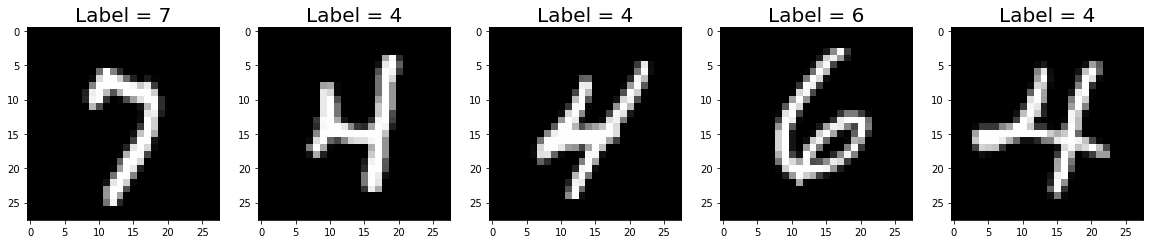

In [14]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)

In [15]:
# NOTE: Run this cell only once. If you have to rerun it multiple times, 
# make sure that you run it after rerunning the previous 2 cells.

# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
# NOTE: we are returning a single mean/std over all the pixels, rather than a pixel-wise one
mean, std = X_train.mean(), X_train.std()  
X_train = (X_train - mean) / (std + 1e-6)  # avoid divide by zero
# X_train /= torch.norm(X_train, dim=(1, 2)).max()

X_test = X_test.float()
X_test = (X_test - mean) / (std + 1e-6)
# X_test /= torch.norm(X_test, dim=(1, 2)).max()

n_class = np.unique(y_train).shape[0]

We now repeat the boilerplate code, with appropriate modifications. 

In [16]:
@torch.no_grad()
def compute_logs(model, verbose=False): # Only report loss
    train_loss = compute_objective(model, X_train)
    test_loss = compute_objective(model, X_test)
    if verbose:
        print('Train Loss = {:.3f}, Test Loss = {:.3f}, '.format(
                train_loss.item(), test_loss.item(),
    ))
    return (train_loss, test_loss)

def minibatch_sgd_one_pass(model, X, learning_rate, batch_size, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(num_examples, size=(batch_size,)) 
        # compute the objective. 
        objective = compute_objective(model, X[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print("{:.3f}".format(average_loss))
        
        # Exercise:
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())

        # Perform the SGD update
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
                
    return model

### Divergent Learning rate
Find the divergent learning rate, using the same procedure as previously. 

This time, make sure the loss decreases substantially with the learning rate you choose across 5-10 different random initializations. A decrease from 400 to 150 is considered substantial but a decrease from 400 to 384 is not. 

In [17]:
learning_rate = 0.0002 # TODO: experiment with it to find the divergent learning rate
batch_size = 1
lower_dimension = 40 # use a lower dimensionality of 40

model = AutoEncoder(lower_dimension)  

_ = compute_logs(model, verbose=True)

model = minibatch_sgd_one_pass(model, X_train, learning_rate, batch_size, verbose=True)
_ = compute_logs(model, verbose=True)


Train Loss = 400.798, Test Loss = 406.494, 
247.970
316.776
303.756
264.518
233.628
208.324
184.874
175.150
163.350
157.710
149.853
141.665
134.397
135.952
132.823
126.119
119.255
118.595
115.087
114.540
111.329
114.869
113.346
109.188
102.397
104.476
99.643
104.889
101.715
99.877
93.089
93.203
92.755
89.619
98.087
93.335
88.522
91.534
86.583
82.448
90.734
92.722
85.978
86.244
88.132
84.906
78.883
84.508
95.113
89.862
86.045
81.691
91.778
87.543
77.846
71.207
72.559
80.469
75.220
72.445
Train Loss = 74.640, Test Loss = 73.955, 


We now train the model for 100 epochs.

In [18]:
learning_rate = 0.0002 # TODO: use half the divergent learning rate

logs = []

model = AutoEncoder(lower_dimension)
print('Iteration 0', end=', ')
logs.append(compute_logs(model, verbose=True))

batch_size = 1

for j in range(20):
    model = minibatch_sgd_one_pass(model, X_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    logs.append(compute_logs(model, verbose=True))



Iteration 0, Train Loss = 394.586, Test Loss = 402.300, 
Iteration 1, Train Loss = 81.401, Test Loss = 80.442, 
Iteration 2, Train Loss = 68.640, Test Loss = 68.221, 
Iteration 3, Train Loss = 57.174, Test Loss = 57.160, 
Iteration 4, Train Loss = 51.397, Test Loss = 51.358, 
Iteration 5, Train Loss = 49.835, Test Loss = 49.661, 
Iteration 6, Train Loss = 48.350, Test Loss = 48.168, 
Iteration 7, Train Loss = 51.351, Test Loss = 51.728, 
Iteration 8, Train Loss = 48.697, Test Loss = 48.754, 
Iteration 9, Train Loss = 44.768, Test Loss = 44.608, 
Iteration 10, Train Loss = 54.746, Test Loss = 54.965, 
Iteration 11, Train Loss = 43.611, Test Loss = 43.906, 
Iteration 12, Train Loss = 42.682, Test Loss = 42.792, 
Iteration 13, Train Loss = 43.360, Test Loss = 43.471, 
Iteration 14, Train Loss = 40.713, Test Loss = 40.979, 
Iteration 15, Train Loss = 40.633, Test Loss = 40.871, 
Iteration 16, Train Loss = 40.278, Test Loss = 40.590, 
Iteration 17, Train Loss = 46.536, Test Loss = 46.908, 


(37.16077003479004, 77.33066101074219)

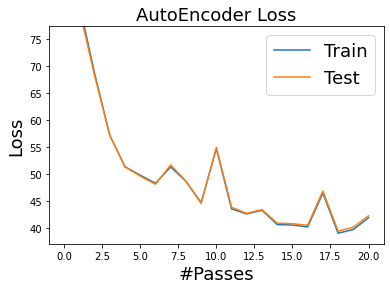

In [19]:
logs_arr = np.asarray(logs)

plt.plot(logs_arr[:, 0], label="Train")
plt.plot(logs_arr[:, 1], label="Test")
plt.title('AutoEncoder Loss', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('#Passes', fontsize=18)
plt.legend(fontsize=18)

# Try to set clever bounds
plt.ylim((logs_arr[1:].reshape(-1).min() * 0.95, logs_arr[1:].reshape(-1).max() * 0.95))

# Reconstruction
Let us reconstruct some training images...

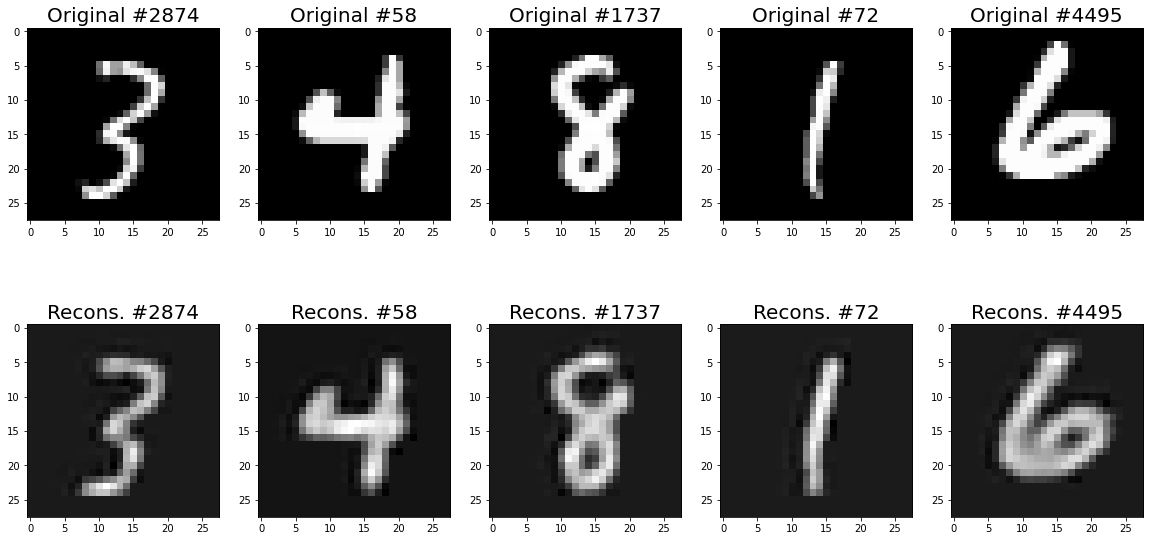

In [20]:
f, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    x = X_train[idx]
    ax[0, i].imshow(x * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[0, i].set_title(f'Original #{idx}', fontsize=20)
    # add batch and channel dimensions before passing through the model and squeeze them out later
    xr = model(x.view(1, 1, 28, 28)).detach().squeeze()
    ax[1, i].imshow(xr * std + mean, cmap='gray') # Note: Undo mean and std normalization before viewing image
    ax[1, i].set_title(f'Recons. #{idx}', fontsize=20)

... and some test images.

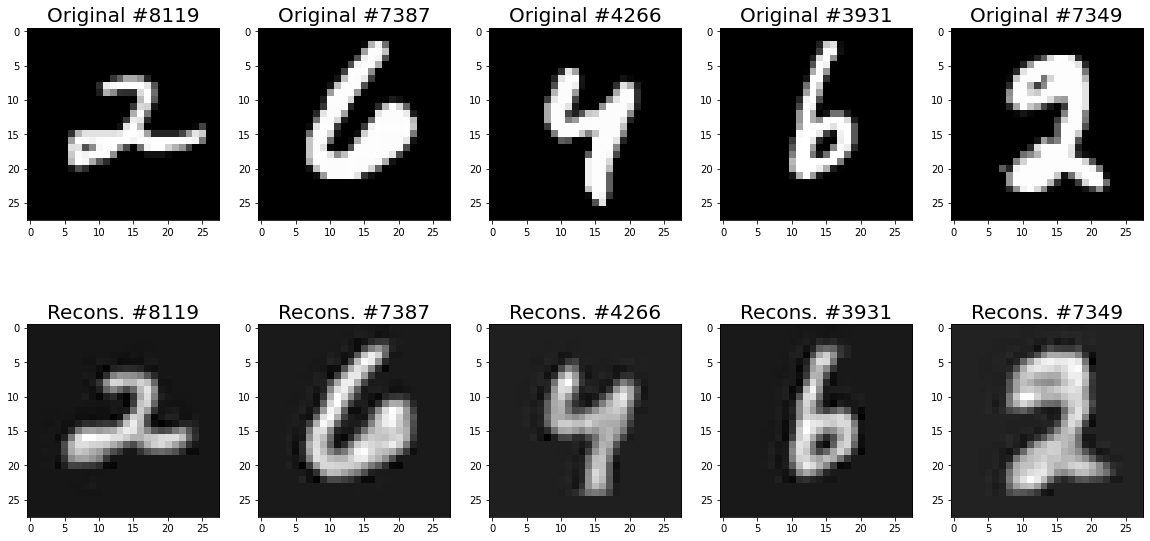

In [21]:
f, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, idx in enumerate(np.random.choice(X_test.shape[0], 5)):
    x = X_test[idx]
    ax[0, i].imshow(x * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[0, i].set_title(f'Original #{idx}', fontsize=20)
    # add batch and channel dimensions before passing through the model and squeeze them out later
    xr = model(x.view(1, 1, 28, 28)).detach().squeeze()
    ax[1, i].imshow(xr * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[1, i].set_title(f'Recons. #{idx}', fontsize=20)

# Can we generate random images?


Let us take a random vector in the projected space (with the correct mean and per-component variance) and try to decode it. What do we get?  

In [22]:
with torch.no_grad():
    x_encoded = model.encode_images(X_train.unsqueeze(1))

    mean_encoded = x_encoded.mean(axis=0)  
    std_encoded = x_encoded.std(axis=0)

    # Random vectors in the encoded space
    random_encoded = torch.randn(5, 40) * std_encoded[None, :] + mean_encoded[None, :] 

    random_decoded = model.decode_representations(random_encoded).squeeze()  # remove channel dimension

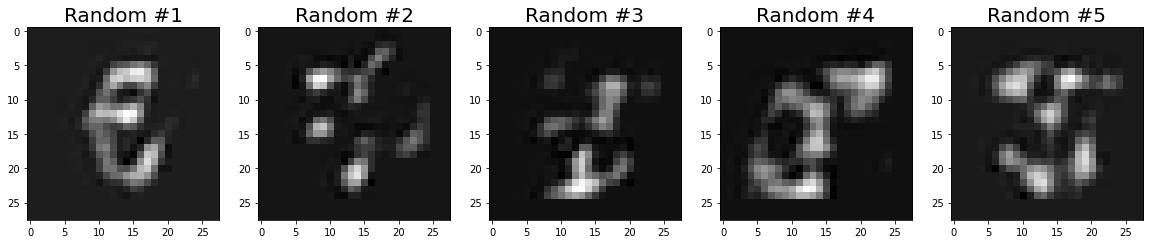

In [23]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(random_decoded[i] * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[i].set_title(f'Random #{i+1}', fontsize=20)

Try this a few times and see if you can get anything resembling digits. 

A generalization of the autoencoder, known as a variational autoencoder (VAE) is designed to handle this case. 
It is trained so that random vectors in the representation space can be decoded to produce novel and realistic looking images. 

# Denoising autoencoders
Autoencoders can be trained to "denoise" an image. In your homework, you will train an autoencoder to get rid of blank patches in an image, as shown in the example below.  

<div>
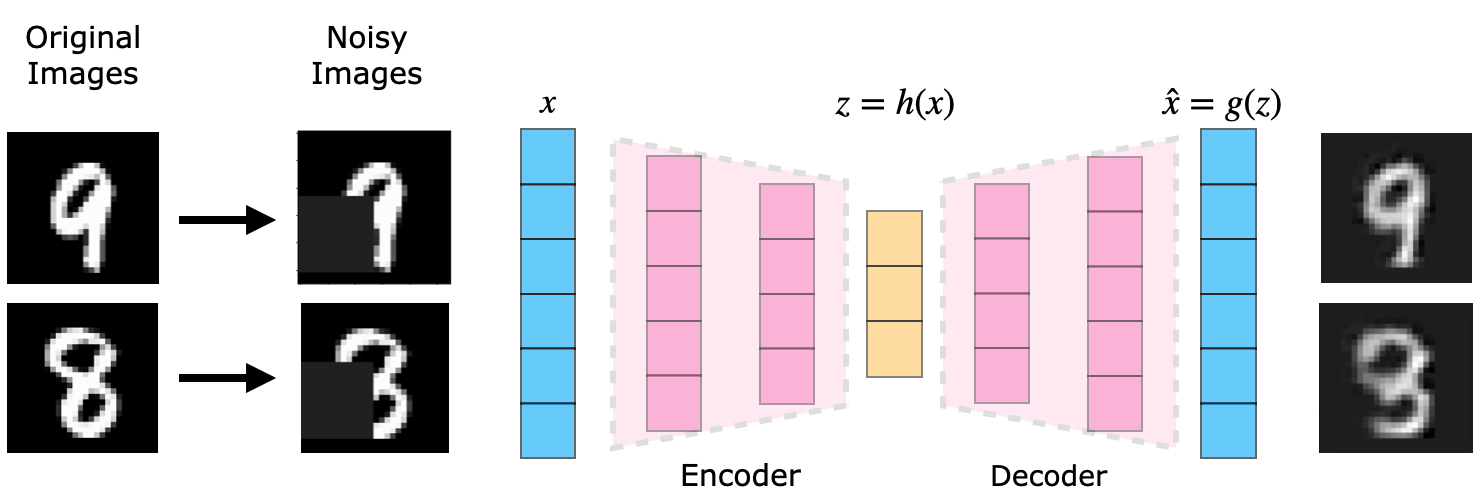
</div>

The autoencoder does a decent job with the first image, but it gets the second one wrong. 

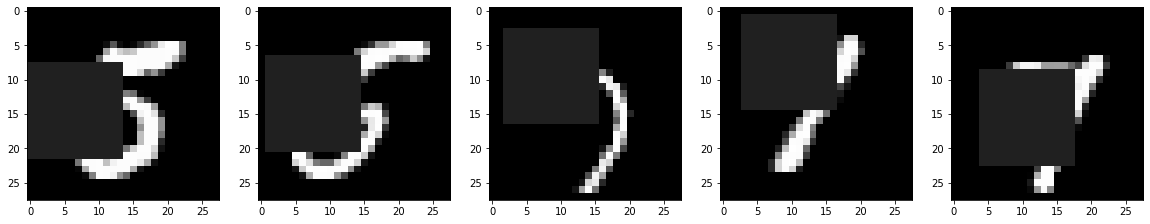

In [24]:
def corrupt_image_batch(images):
    # Add a 10x10 square of zeros in a 28x28 image
    # images: (B, 1, 28, 28)
    patch_size = 14  # zero out a 14x14 patch
    batch_size = images.shape[0]
    height, width = images.shape[-2:]  # height and width of each image

    starting_h = np.random.choice(height - patch_size, size=batch_size, replace=True)
    starting_w = np.random.choice(width - patch_size, size=batch_size, replace=True)

    images_corrupted = images.clone()  # corrupt a copy so we do not lose the originals
    for b in range(batch_size):
        h = starting_h[b]
        w = starting_w[b]
        images_corrupted[b, 0, h:h+patch_size, b:b+patch_size] = 0  # set to 0
    return images_corrupted

images = X_train[np.random.choice(X_train.shape[0], 5)].unsqueeze(1)
images_corrupted = corrupt_image_batch(images)

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(images_corrupted[i].squeeze() * std + mean, cmap='gray', vmin=0, vmax=255)